## 1) Loading CIFAR dataset

You should load the CIFAR dataset. You can use [the pytorch CIFAR tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). As was done in the previous exercise, you should define a dictionary of ``dataloaders``. For now, no need to define pre-process to the data. 
Please stick to the API of H.W_1, create a dataloaders disctionary ``{'train','val'}``

You can use batch_size = 128

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import time, copy, os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create a folder for our data
# The ! prefix runs this as a shell command
!mkdir data
!mkdir data/CIFAR10

In [3]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
### Enter you code here

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data/CIFAR10/train', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data/CIFAR10/val', train=False,
                                       download=True, transform=transform)


dataloaders = {
    'train': torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  }

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/train/cifar-10-python.tar.gz to ./data/CIFAR10/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/val/cifar-10-python.tar.gz to ./data/CIFAR10/val


In [4]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 50000, 'val': 10000}


In [5]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Change the network

In [23]:
print(f'photos size: {trainset[0][0].shape}')

photos size: torch.Size([3, 32, 32])


filters size: we decided to use small filters because as we saw on VGG16 net when we have small filter on more layers we get more deeper network that raise up the complexity, with less linearity and less parameters to optimaize.
As a first try we decided to take a block from VGG16 net which consider all the tips we got on the home assignment instructions.(cov,cov,pool)

In [50]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)     
        )
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16384, 100), #first layer 100 neurons
            nn.ReLU(),
            nn.Linear(100, 20), #second layer 20 neurons
            nn.ReLU(),
            nn.Linear(20, 10), #third layer 10 elements
            nn.LogSoftmax(dim=1) #output
        )


    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [51]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16384, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


In [52]:
from torchsummary import summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2           [-1, 64, 32, 32]          36,928
         MaxPool2d-3           [-1, 64, 16, 16]               0
           Flatten-4                [-1, 16384]               0
            Linear-5                  [-1, 100]       1,638,500
              ReLU-6                  [-1, 100]               0
            Linear-7                   [-1, 20]           2,020
              ReLU-8                   [-1, 20]               0
            Linear-9                   [-1, 10]             210
       LogSoftmax-10                   [-1, 10]               0
Total params: 1,679,450
Trainable params: 1,679,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.25
Params size (MB): 6.41
Estimat

In [53]:
# If a GPU is available, make the model use it
model = model.to(device)

criterion = nn.NLLLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 15

In [54]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_loss_train = []
    epoch_loss_val = []
    epoch_acc_train = []
    epoch_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) #the max probability from each row place 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()
                epoch_loss_train.append(epoch_loss)  
                epoch_acc_train.append(epoch_acc.item())
            
            else:
              epoch_loss_val.append(epoch_loss)
              epoch_acc_val.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss_train, epoch_acc_train, epoch_loss_val, epoch_acc_val

In [55]:
model, epoch_loss_train, epoch_acc_train, epoch_loss_val, epoch_acc_val = train_model(model, dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 2.0046 Acc: 0.2772
val Loss: 1.7064 Acc: 0.3922

Epoch 1/14
----------
train Loss: 1.6013 Acc: 0.4247
val Loss: 1.4949 Acc: 0.4674

Epoch 2/14
----------
train Loss: 1.4360 Acc: 0.4882
val Loss: 1.3918 Acc: 0.5001

Epoch 3/14
----------
train Loss: 1.3225 Acc: 0.5288
val Loss: 1.2958 Acc: 0.5346

Epoch 4/14
----------
train Loss: 1.2223 Acc: 0.5664
val Loss: 1.2257 Acc: 0.5645

Epoch 5/14
----------
train Loss: 1.1365 Acc: 0.5959
val Loss: 1.1711 Acc: 0.5810

Epoch 6/14
----------
train Loss: 1.0548 Acc: 0.6273
val Loss: 1.1358 Acc: 0.5956

Epoch 7/14
----------
train Loss: 0.9399 Acc: 0.6714
val Loss: 1.0896 Acc: 0.6152

Epoch 8/14
----------
train Loss: 0.9188 Acc: 0.6795
val Loss: 1.0845 Acc: 0.6196

Epoch 9/14
----------
train Loss: 0.9054 Acc: 0.6836
val Loss: 1.0803 Acc: 0.6211

Epoch 10/14
----------
train Loss: 0.8928 Acc: 0.6875
val Loss: 1.0781 Acc: 0.6203

Epoch 11/14
----------
train Loss: 0.8819 Acc: 0.6910
val Loss: 1.0725 Acc: 0.6229

Ep

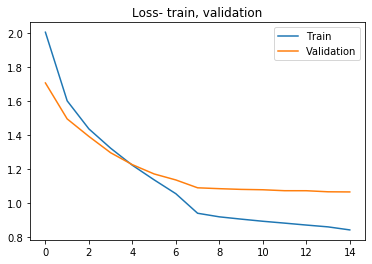

In [56]:
plt.plot(epoch_loss_train, label="Train")
plt.plot(epoch_loss_val, label= "Validation")
plt.legend()
plt.title('Loss- train, validation')
plt.show()

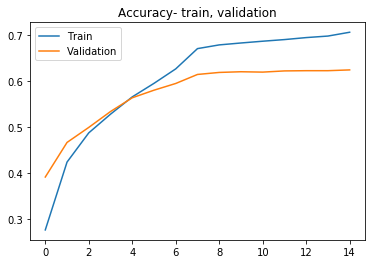

In [57]:
plt.plot(epoch_acc_train, label="Train")
plt.plot(epoch_acc_val, label= "Validation")
plt.legend()
plt.title('Accuracy- train, validation')
plt.show()